#### In this notebook first trained models with the imbalance data and then using SMOTE for class balancing and trained all the models by training the data as training and validation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import gc

import warnings
warnings.filterwarnings('ignore')

#increase visibility to see all columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [2]:
#transactions = pd.read_csv('D:\\Upgrad\\LJMU\\data\\fraud\\train_transaction.csv')
transactions = pd.read_csv('train_transaction.csv')
print(transactions.shape)

(590540, 394)


### Data Cleaning

In [1]:
### Removing the columns for which 90% of data is null or 90% of data is a unique value

In [3]:
def check_NA_Cols_by_percentage(data, percentage) :
    all_cols = data.isnull().sum()
    print(percentage*len(data))
    na_cols = all_cols[all_cols.values >= (percentage*len(data))]
    print("count of columns where", percentage*100,"% of data is NA : ",len(na_cols))
    print("list of columns where values are NA : \n ", list(na_cols.index))
    return list(na_cols.index)                                          
    

In [4]:
na_cols = check_NA_Cols_by_percentage(transactions, 0.9)    

531486.0
count of columns where 90.0 % of data is NA :  2
list of columns where values are NA : 
  ['dist2', 'D7']


In [5]:
def check_top_values(data, percentage) :
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > percentage]
    return big_top_value_cols

In [6]:
top_value_cols = check_top_values(transactions, 0.9)    
print(top_value_cols)

['isFraud', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321']


In [7]:
drop_cols = list(set(na_cols + top_value_cols))

In [8]:
drop_cols.remove('isFraud')

In [9]:
transactions = transactions.drop(drop_cols, axis=1)

In [10]:
import gc
gc.collect()

11

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
transactions = reduce_mem_usage(transactions)

Mem. usage decreased to 1836.57 Mb (0.6% reduction)


In [13]:
#identity = pd.read_csv('D:\\Upgrad\\LJMU\\data\\fraud\\train_identity.csv')
identity = pd.read_csv('train_identity.csv')

In [14]:
identity.head(2)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [15]:
identity_na_cols = check_NA_Cols_by_percentage(identity, 0.9)

129809.7
count of columns where 90.0 % of data is NA :  9
list of columns where values are NA : 
  ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [16]:
identity_top_value_cols = check_top_values(identity, 0.9)    
print(identity_top_value_cols)

['id_07', 'id_08', 'id_11', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_36']


In [17]:
identity_drop_cols = list(set(identity_na_cols + identity_top_value_cols))

In [18]:
identity_drop_cols

['id_11',
 'id_08',
 'id_36',
 'id_25',
 'id_26',
 'id_07',
 'id_27',
 'id_22',
 'id_23',
 'id_21',
 'id_24']

In [19]:
identity = identity.drop(identity_drop_cols, axis=1)

In [20]:
identity = reduce_mem_usage(identity)

Mem. usage decreased to 131.21 Mb (0.4% reduction)


In [21]:
joindf = transactions.merge(identity, on='TransactionID', how='left')

In [22]:
del transactions, identity

In [23]:
X_train = joindf.drop('isFraud', axis=1)

In [24]:
y_train = joindf['isFraud'].copy()

In [25]:
train_cols = X_train.columns

In [26]:
del joindf

In [27]:
from sklearn import preprocessing
for f in X_train.columns:
    if X_train[f].dtype=='object' :
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))

In [28]:
X_train.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,2,2,2,2,1742
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [29]:
X_train = X_train.fillna(-999)

In [30]:
X_train.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2,-999.0,-999.0,3,2,-999.0,-999.0,-999.0,-999.0,2,2,74,103,-999.0,260,4,2,2,2,2,1742
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,-999.0,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [32]:
cols = X_train.columns

In [33]:
del X_train

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y_train, test_size=0.40, random_state=100)

In [4]:
def dumpModel(fileName, model):
    rf_model_pkl = open(fileName, 'wb')
    pickle.dump(model, rf_model_pkl)
    rf_model_pkl.close()
    return

In [5]:
def loadModel(fileName):
    model_pkl = open(fileName, 'rb')
    model = pickle.load(model_pkl)
    print("Loaded model :: ", model)
    return model

In [6]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [7]:
def model_metrics(y_test, predictions, modelName):
    print("Printing the metrics for Model : ", modelName)
    print("confusion matrix")
    print(confusion_matrix(y_test,predictions))
    print("Classification report: ")
    print(classification_report(y_test, predictions))
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

### Training the models using imbalanced data 

### xgboost Model

In [37]:
import xgboost as xgb

In [57]:
# hyperparameter tuning with XGBoost
from sklearn.model_selection import GridSearchCV
folds = 3

param_grid = {'learning_rate': [0.05,0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=1000, colsample_bytree=0.9,
                        tree_method='gpu_hist')

model_xgb_cv = GridSearchCV(estimator = xgb_model, 
                        n_jobs=2,
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [58]:
model_xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 434.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.9, max_depth=10,
                                     n_estimators=1000,
                                     tree_method='gpu_hist'),
             n_jobs=2,
             param_grid={'learning_rate': [0.05, 0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [59]:
xgb_cv_results = pd.DataFrame(model_xgb_cv.cv_results_)
xgb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1326.579836,39.469718,9.815589,5.182198,0.05,0.3,"{'learning_rate': 0.05, 'subsample': 0.3}",0.950373,0.953514,0.953345,0.952411,0.001443,4,0.999915,0.999869,0.999828,0.999871,3.565391e-05
1,1875.956130,64.136383,6.301434,0.005226,0.05,0.6,"{'learning_rate': 0.05, 'subsample': 0.6}",0.955381,0.956939,0.958037,0.956786,0.001090,2,0.999993,0.999982,0.999974,0.999983,7.912845e-06
2,2176.293155,35.322884,6.406548,0.004839,0.05,0.9,"{'learning_rate': 0.05, 'subsample': 0.9}",0.957155,0.958890,0.959656,0.958567,0.001046,1,0.999980,0.999910,0.999920,0.999936,3.085282e-05
3,1412.899075,24.067022,5.456735,0.013668,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.941463,0.941246,0.944703,0.942471,0.001581,7,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,2087.471281,54.858094,5.630724,0.031960,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.949378,0.950012,0.952628,0.950673,0.001406,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,2414.302343,34.991227,5.987323,0.014848,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.952593,0.952686,0.957087,0.954122,0.002097,3,1.000000,1.000000,1.000000,1.000000,0.000000e+00
6,1323.978690,17.979433,4.609068,0.005568,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.921146,0.923347,0.921828,0.922107,0.000920,9,1.000000,1.000000,1.000000,1.000000,6.409876e-17
7,1993.518376,42.274624,4.547874,0.007491,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.939226,0.940120,0.943702,0.941016,0.001934,8,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,2394.855125,304.392665,4.917075,0.046209,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.946418,0.947106,0.949086,0.947537,0.001131,6,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [60]:
predictions_xgb_cv = model_xgb_cv.predict(X_valid)

### xgBoost model Metrics

Printing the metrics for Model :  XGB Cross Validation
confusion matrix
[[227891    209]
 [  3070   5046]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228100
           1       0.96      0.62      0.75      8116

    accuracy                           0.99    236216
   macro avg       0.97      0.81      0.87    236216
weighted avg       0.99      0.99      0.98    236216

Accuracy for the test dataset 98.6%
ROC for the test dataset 81.0%


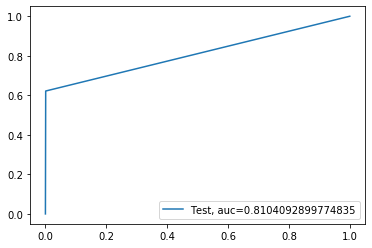

In [61]:
model_metrics(y_valid, predictions_xgb_cv, "XGB Cross Validation")

In [10]:
import pickle

In [63]:
Pkl_Filename_xgb_cv = "Pickle_xgb_gpu_cv_std.pkl"  

In [64]:
dumpModel(Pkl_Filename_xgb_cv, model_xgb_cv)

In [65]:
xgb_cv_model = loadModel(Pkl_Filename_xgb_cv)

Loaded model ::  GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.9, max_depth=10,
                                     missing=nan, n_estimators=1000,
                                     tree_method='gpu_hist'),
             n_jobs=2,
             param_grid={'learning_rate': [0.05, 0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)


In [66]:
predictions_xgb_cv = xgb_cv_model.predict(X_valid)

Printing the metrics for Model :  XGB Cross Validation
confusion matrix
[[227891    209]
 [  3070   5046]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228100
           1       0.96      0.62      0.75      8116

    accuracy                           0.99    236216
   macro avg       0.97      0.81      0.87    236216
weighted avg       0.99      0.99      0.98    236216

Accuracy for the test dataset 98.6%
ROC for the test dataset 81.0%


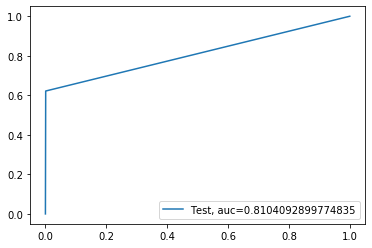

In [67]:
model_metrics(y_valid, predictions_xgb_cv, "XGB Cross Validation")

In [49]:
xbg_clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='gpu_hist'
)

In [50]:
xbg_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              n_estimators=1000, subsample=0.9, tree_method='gpu_hist')

In [51]:
Pkl_Filename_xgb_normal = "Pickle_xgb_normal.pkl"  

In [52]:
dumpModel(Pkl_Filename_xgb_normal, xbg_clf)

In [53]:
xgb_model = loadModel(Pkl_Filename_xgb_normal)

Loaded model ::  XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              missing=nan, n_estimators=1000, subsample=0.9,
              tree_method='gpu_hist')


In [54]:
predictions_xgb = xgb_model.predict(X_valid)

Printing the metrics for Model :  XGB Model with Hyper Parameters
confusion matrix
[[227899    201]
 [  3064   5052]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228100
           1       0.96      0.62      0.76      8116

    accuracy                           0.99    236216
   macro avg       0.97      0.81      0.87    236216
weighted avg       0.99      0.99      0.98    236216

Accuracy for the test dataset 98.6%
ROC for the test dataset 81.1%


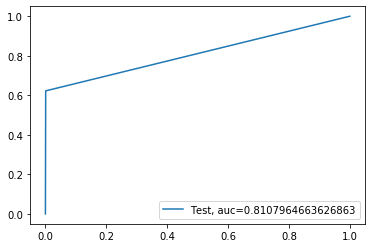

In [55]:
model_metrics(y_valid, predictions_xgb, "XGB Model with Hyper Parameters")

Printing the metrics for Model :  XGB Model with Hyper Parameters
confusion matrix
[[227887    213]
 [  3094   5022]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228100
           1       0.96      0.62      0.75      8116

    accuracy                           0.99    236216
   macro avg       0.97      0.81      0.87    236216
weighted avg       0.99      0.99      0.98    236216

Accuracy for the test dataset 98.6%
ROC for the test dataset 80.9%


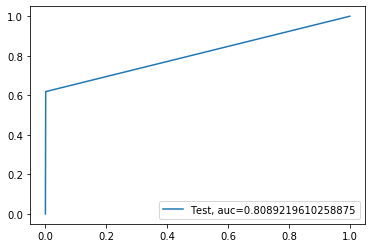

In [48]:
model_metrics(y_valid, predictions_xgb, "XGB Model with Hyper Parameters")

### Training catboost model

In [58]:
from catboost import CatBoostClassifier

In [59]:
model_catboost_normal = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01)

In [60]:
model_catboost_normal.fit(X_train, y_train)

0:	total: 292ms	remaining: 4m 51s
1:	total: 472ms	remaining: 3m 55s
2:	total: 704ms	remaining: 3m 54s
3:	total: 916ms	remaining: 3m 47s
4:	total: 1.15s	remaining: 3m 49s
5:	total: 1.35s	remaining: 3m 44s
6:	total: 1.57s	remaining: 3m 42s
7:	total: 1.75s	remaining: 3m 37s
8:	total: 1.98s	remaining: 3m 37s
9:	total: 2.22s	remaining: 3m 39s
10:	total: 2.43s	remaining: 3m 38s
11:	total: 2.61s	remaining: 3m 35s
12:	total: 2.84s	remaining: 3m 35s
13:	total: 3.03s	remaining: 3m 33s
14:	total: 3.21s	remaining: 3m 31s
15:	total: 3.42s	remaining: 3m 30s
16:	total: 3.62s	remaining: 3m 29s
17:	total: 3.84s	remaining: 3m 29s
18:	total: 4.03s	remaining: 3m 27s
19:	total: 4.21s	remaining: 3m 26s
20:	total: 4.41s	remaining: 3m 25s
21:	total: 4.6s	remaining: 3m 24s
22:	total: 4.8s	remaining: 3m 23s
23:	total: 5.01s	remaining: 3m 23s
24:	total: 5.22s	remaining: 3m 23s
25:	total: 5.42s	remaining: 3m 23s
26:	total: 5.64s	remaining: 3m 23s
27:	total: 5.85s	remaining: 3m 22s
28:	total: 6.02s	remaining: 3m 2

235:	total: 52s	remaining: 2m 48s
236:	total: 52.2s	remaining: 2m 48s
237:	total: 52.4s	remaining: 2m 47s
238:	total: 52.7s	remaining: 2m 47s
239:	total: 52.9s	remaining: 2m 47s
240:	total: 53.2s	remaining: 2m 47s
241:	total: 53.4s	remaining: 2m 47s
242:	total: 53.6s	remaining: 2m 46s
243:	total: 53.9s	remaining: 2m 46s
244:	total: 54.1s	remaining: 2m 46s
245:	total: 54.3s	remaining: 2m 46s
246:	total: 54.5s	remaining: 2m 46s
247:	total: 54.7s	remaining: 2m 45s
248:	total: 55s	remaining: 2m 45s
249:	total: 55.2s	remaining: 2m 45s
250:	total: 55.5s	remaining: 2m 45s
251:	total: 55.7s	remaining: 2m 45s
252:	total: 55.9s	remaining: 2m 45s
253:	total: 56.2s	remaining: 2m 44s
254:	total: 56.4s	remaining: 2m 44s
255:	total: 56.7s	remaining: 2m 44s
256:	total: 56.9s	remaining: 2m 44s
257:	total: 57.2s	remaining: 2m 44s
258:	total: 57.4s	remaining: 2m 44s
259:	total: 57.6s	remaining: 2m 44s
260:	total: 57.9s	remaining: 2m 43s
261:	total: 58.1s	remaining: 2m 43s
262:	total: 58.4s	remaining: 2m 

460:	total: 1m 45s	remaining: 2m 2s
461:	total: 1m 45s	remaining: 2m 2s
462:	total: 1m 45s	remaining: 2m 2s
463:	total: 1m 45s	remaining: 2m 2s
464:	total: 1m 46s	remaining: 2m 2s
465:	total: 1m 46s	remaining: 2m 1s
466:	total: 1m 46s	remaining: 2m 1s
467:	total: 1m 46s	remaining: 2m 1s
468:	total: 1m 47s	remaining: 2m 1s
469:	total: 1m 47s	remaining: 2m 1s
470:	total: 1m 47s	remaining: 2m
471:	total: 1m 47s	remaining: 2m
472:	total: 1m 47s	remaining: 2m
473:	total: 1m 48s	remaining: 2m
474:	total: 1m 48s	remaining: 1m 59s
475:	total: 1m 48s	remaining: 1m 59s
476:	total: 1m 48s	remaining: 1m 59s
477:	total: 1m 49s	remaining: 1m 59s
478:	total: 1m 49s	remaining: 1m 58s
479:	total: 1m 49s	remaining: 1m 58s
480:	total: 1m 49s	remaining: 1m 58s
481:	total: 1m 49s	remaining: 1m 58s
482:	total: 1m 50s	remaining: 1m 57s
483:	total: 1m 50s	remaining: 1m 57s
484:	total: 1m 50s	remaining: 1m 57s
485:	total: 1m 50s	remaining: 1m 57s
486:	total: 1m 51s	remaining: 1m 57s
487:	total: 1m 51s	remainin

684:	total: 2m 35s	remaining: 1m 11s
685:	total: 2m 35s	remaining: 1m 11s
686:	total: 2m 36s	remaining: 1m 11s
687:	total: 2m 36s	remaining: 1m 10s
688:	total: 2m 36s	remaining: 1m 10s
689:	total: 2m 36s	remaining: 1m 10s
690:	total: 2m 37s	remaining: 1m 10s
691:	total: 2m 37s	remaining: 1m 10s
692:	total: 2m 37s	remaining: 1m 9s
693:	total: 2m 37s	remaining: 1m 9s
694:	total: 2m 38s	remaining: 1m 9s
695:	total: 2m 38s	remaining: 1m 9s
696:	total: 2m 38s	remaining: 1m 8s
697:	total: 2m 38s	remaining: 1m 8s
698:	total: 2m 38s	remaining: 1m 8s
699:	total: 2m 39s	remaining: 1m 8s
700:	total: 2m 39s	remaining: 1m 8s
701:	total: 2m 39s	remaining: 1m 7s
702:	total: 2m 39s	remaining: 1m 7s
703:	total: 2m 40s	remaining: 1m 7s
704:	total: 2m 40s	remaining: 1m 7s
705:	total: 2m 40s	remaining: 1m 6s
706:	total: 2m 40s	remaining: 1m 6s
707:	total: 2m 41s	remaining: 1m 6s
708:	total: 2m 41s	remaining: 1m 6s
709:	total: 2m 41s	remaining: 1m 5s
710:	total: 2m 41s	remaining: 1m 5s
711:	total: 2m 41s	r

915:	total: 3m 27s	remaining: 19.1s
916:	total: 3m 27s	remaining: 18.8s
917:	total: 3m 28s	remaining: 18.6s
918:	total: 3m 28s	remaining: 18.4s
919:	total: 3m 28s	remaining: 18.1s
920:	total: 3m 28s	remaining: 17.9s
921:	total: 3m 29s	remaining: 17.7s
922:	total: 3m 29s	remaining: 17.5s
923:	total: 3m 29s	remaining: 17.2s
924:	total: 3m 29s	remaining: 17s
925:	total: 3m 30s	remaining: 16.8s
926:	total: 3m 30s	remaining: 16.6s
927:	total: 3m 30s	remaining: 16.3s
928:	total: 3m 30s	remaining: 16.1s
929:	total: 3m 30s	remaining: 15.9s
930:	total: 3m 31s	remaining: 15.7s
931:	total: 3m 31s	remaining: 15.4s
932:	total: 3m 31s	remaining: 15.2s
933:	total: 3m 31s	remaining: 15s
934:	total: 3m 32s	remaining: 14.7s
935:	total: 3m 32s	remaining: 14.5s
936:	total: 3m 32s	remaining: 14.3s
937:	total: 3m 32s	remaining: 14.1s
938:	total: 3m 32s	remaining: 13.8s
939:	total: 3m 33s	remaining: 13.6s
940:	total: 3m 33s	remaining: 13.4s
941:	total: 3m 33s	remaining: 13.2s
942:	total: 3m 33s	remaining: 12

In [61]:
Pkl_Filename_catboost = "Pickle_cat_boost_normal.pkl"

In [62]:
dumpModel(Pkl_Filename_catboost, model_catboost_normal)

In [63]:
catboost_model_normal = loadModel(Pkl_Filename_catboost)

Loaded model ::  <catboost.core.CatBoostClassifier object at 0x7f6b2c0f3780>


In [64]:
predictions_catboost = catboost_model_normal.predict(X_valid)

### Catboost model metrics

Printing the metrics for Model :  Catboost Model
confusion matrix
[[227801    299]
 [  5418   2698]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    228100
           1       0.90      0.33      0.49      8116

    accuracy                           0.98    236216
   macro avg       0.94      0.67      0.74    236216
weighted avg       0.97      0.98      0.97    236216

Accuracy for the test dataset 97.6%
ROC for the test dataset 66.6%


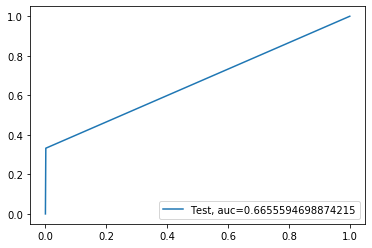

In [65]:
model_metrics(y_valid, predictions_catboost, "Catboost Model")

### Training Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
from sklearn.model_selection import GridSearchCV

n_folds = 5

params = {'bootstrap': [True, False]}

rf_normal = RandomForestClassifier(
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=20,
                             n_estimators=200)
rf_normal_cv = GridSearchCV(rf_normal, params, cv=n_folds, scoring='neg_mean_squared_error')
rf_normal_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=20,
                                              min_samples_leaf=100,
                                              min_samples_split=200,
                                              n_estimators=200),
             param_grid={'bootstrap': [True, False]},
             scoring='neg_mean_squared_error')

In [69]:
Pkl_Filename_rf_cv = "Pickle_rf_normal.pkl"  

In [70]:
dumpModel(Pkl_Filename_rf_cv, rf_normal_cv)

In [71]:
rf_model_normal = loadModel(Pkl_Filename_rf_cv)

Loaded model ::  GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=20,
                                              min_samples_leaf=100,
                                              min_samples_split=200,
                                              n_estimators=200),
             param_grid={'bootstrap': [True, False]},
             scoring='neg_mean_squared_error')


In [72]:
predictions_rf_cv = rf_model_normal.predict(X_valid)

### Randoom Forest model metrics

Printing the metrics for Model :  Random Forest Model Cross Validation
confusion matrix
[[227828    272]
 [  6279   1837]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    228100
           1       0.87      0.23      0.36      8116

    accuracy                           0.97    236216
   macro avg       0.92      0.61      0.67    236216
weighted avg       0.97      0.97      0.96    236216

Accuracy for the test dataset 97.2%
ROC for the test dataset 61.3%


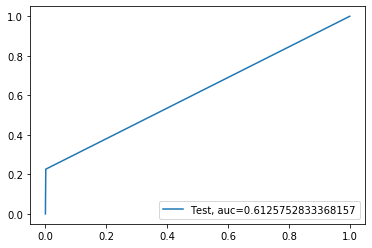

In [73]:
model_metrics(y_valid, predictions_rf_cv, "Random Forest Model Cross Validation")

### Training lightGBM Model

In [74]:
import lightgbm as lgb

In [75]:
# hyperparameter tuning with LightGBM
from sklearn.model_selection import GridSearchCV
folds = 3


param_grid = {'learning_rate': [0.01,0.05, 0.1], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': [500,1000]}          




lgbm_model_normal = lgb.LGBMClassifier(bagging_fraction=0.8, max_depth=10, feature_fraction=0.4,
                                  boosting_type='gbdt')


model_lgbm_cv_normal = GridSearchCV(estimator = lgbm_model_normal, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [76]:
model_lgbm_cv_normal.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 145.7min finished


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=3,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      feature_fraction=0.4, max_depth=10),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [500, 1000],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [77]:
Pkl_Filename_lgbm_cv = "Pickle_lgbm_normal_cv.pkl"

In [78]:
dumpModel(Pkl_Filename_lgbm_cv, model_lgbm_cv_normal)

In [79]:
lgbm_model_normal_cv = loadModel(Pkl_Filename_lgbm_cv)

Loaded model ::  GridSearchCV(cv=3,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      feature_fraction=0.4, max_depth=10),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [500, 1000],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)


In [80]:
predictions_lgbm_cv = lgbm_model_normal_cv.predict(X_valid)

### lightGBM model metrics

Printing the metrics for Model :  Light GBM Model Cross Validation
confusion matrix
[[227816    284]
 [  3387   4729]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228100
           1       0.94      0.58      0.72      8116

    accuracy                           0.98    236216
   macro avg       0.96      0.79      0.86    236216
weighted avg       0.98      0.98      0.98    236216

Accuracy for the test dataset 98.4%
ROC for the test dataset 79.1%


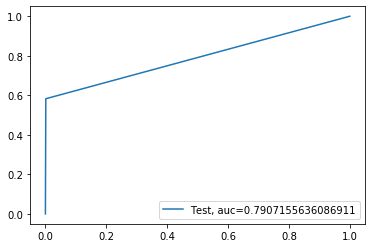

In [81]:
model_metrics(y_valid, predictions_lgbm_cv, "Light GBM Model Cross Validation")

### Training Adaboost model

In [44]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
ada_boost = AdaBoostClassifier(n_estimators=500, random_state=0)

In [38]:
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=0)

In [39]:
Pkl_Filename_ada = "Pickle_ada_gpu_std_normal.pkl"  

In [46]:
dumpModel(Pkl_Filename_ada, ada_boost)

In [47]:
ada_boost_model = loadModel(Pkl_Filename_ada)

Loaded model ::  AdaBoostClassifier(n_estimators=500, random_state=0)


In [52]:
predictions_ada = ada_boost_model.predict(X_valid)

### Ada boost model with imbalanced data

Printing the metrics for Model :  Ada Boost Classification with actual data
confusion matrix
[[   365 227735]
 [    17   8099]]
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.00      0.00    228100
           1       0.03      1.00      0.07      8116

    accuracy                           0.04    236216
   macro avg       0.49      0.50      0.03    236216
weighted avg       0.92      0.04      0.01    236216

Accuracy for the test dataset 3.6%
ROC for the test dataset 50.0%


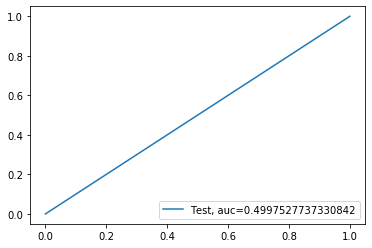

In [53]:
model_metrics(y_valid, predictions_ada, "Ada Boost Classification with actual data")

## Handling Class imbalance Using SMOTE

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_std, y_train.ravel())

In [40]:
del X_train, X_std

In [40]:
del X_std

In [41]:
X_train_res.shape

(1139754, 366)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_res, y_train_res, test_size=0.40, random_state=100)

In [43]:
del X_train_res

### Training XgBoost model

In [15]:
import xgboost as xgb

In [83]:
# hyperparameter tuning with XGBoost
from sklearn.model_selection import GridSearchCV
folds = 3

param_grid = {'learning_rate': [0.05,0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=500, colsample_bytree=0.9,
                        tree_method='gpu_hist')

model_xgb_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [ ]:
model_xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [85]:
Pkl_Filename_xgb_smote_cv = "Pickle_xgb_gpu_smote_cv.pkl" 

In [87]:
dumpModel(Pkl_Filename_xgb_smote_cv, model_xgb_cv)

In [88]:
xgb_model_smote_cv = loadModel(Pkl_Filename_xgb_smote_cv)

Loaded model ::  GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.9, max_depth=10,
                                     missing=nan, n_estimators=500,
                                     tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.05, 0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)


In [89]:
predictions_xgb_model_smote_cv = xgb_model_smote_cv.predict(X_valid)

### xgb Model metrics

Printing the metrics for Model :  XGB Classification with Cross Validation and SMOTE
confusion matrix
[[227369    306]
 [  2673 225554]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    227675
           1       1.00      0.99      0.99    228227

    accuracy                           0.99    455902
   macro avg       0.99      0.99      0.99    455902
weighted avg       0.99      0.99      0.99    455902

Accuracy for the test dataset 99.3%
ROC for the test dataset 99.3%


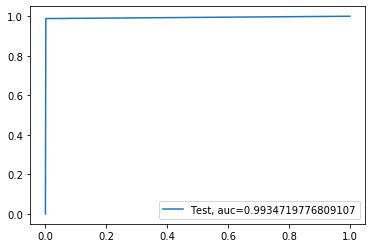

In [90]:
model_metrics(y_valid, predictions_xgb_model_smote_cv, "XGB Classification with Cross Validation and SMOTE")

In [45]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='gpu_hist',
    n_jobs=2
)

In [46]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              n_estimators=1000, n_jobs=2, subsample=0.9,
              tree_method='gpu_hist')

In [9]:
Pkl_Filename_xgb_smote = "Pickle_xgb_gpu_smote.pkl" 

In [50]:
dumpModel(Pkl_Filename_xgb_smote, xgb_clf)

In [51]:
xgb_model_smote = loadModel(Pkl_Filename_xgb_smote)

Loaded model ::  XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              missing=nan, n_estimators=1000, n_jobs=2, subsample=0.9,
              tree_method='gpu_hist')


In [52]:
predictions_xgb_model_smote = xgb_model_smote.predict(X_valid)

Printing the metrics for Model :  XGB Classification with Hyperparameters and SMOTE
confusion matrix
[[227353    322]
 [  3101 225126]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    227675
           1       1.00      0.99      0.99    228227

    accuracy                           0.99    455902
   macro avg       0.99      0.99      0.99    455902
weighted avg       0.99      0.99      0.99    455902

Accuracy for the test dataset 99.2%
ROC for the test dataset 99.2%


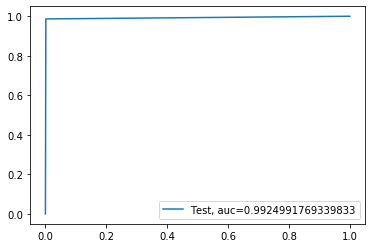

In [53]:
model_metrics(y_valid, predictions_xgb_model_smote, "XGB Classification with Hyperparameters and SMOTE")

In [11]:
xgb_model_smote = loadModel(Pkl_Filename_xgb_smote)

Loaded model ::  XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              missing=nan, n_estimators=1000, n_jobs=2, subsample=0.9,
              tree_method='gpu_hist')


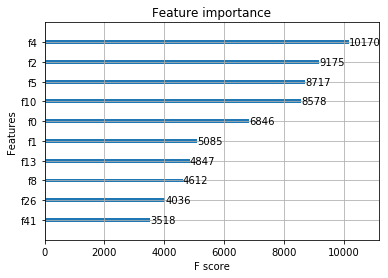

In [12]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(xgb_model_smote, max_num_features=10) 
plt.show()

In [80]:
importances = xgb_model_smote.feature_importances_
col_names =  cols

XG_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
XG_imp_features = XG_feature_importance.head(20)

### Top 50 important features from xgBoost model

In [81]:
XG_imp_features

,colName,value
0,0.051271,card1
1,0.046255,TransactionAmt
2,0.043946,card2
3,0.043245,addr1
4,0.034514,TransactionID
5,0.025636,TransactionDT
6,0.024436,P_emaildomain
7,0.023251,card5
8,0.020347,C13
9,0.017736,D15


In [49]:
import pickle

In [65]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [66]:
def model_metrics(y_test, predictions):
    print("confusion matrix")
    print(confusion_matrix(y_test,predictions))
    print("Classification report: ")
    print(classification_report(y_test, predictions))
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

confusion matrix
[[227334    341]
 [  2846 225381]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    227675
           1       1.00      0.99      0.99    228227

    accuracy                           0.99    455902
   macro avg       0.99      0.99      0.99    455902
weighted avg       0.99      0.99      0.99    455902

Accuracy for the test dataset 99.3%
ROC for the test dataset 99.3%


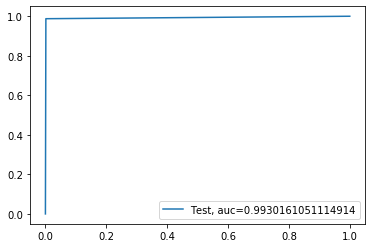

In [35]:
model_metrics(y_valid, predictions_xgb_smote)

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
print( "  auc = ", roc_auc_score(y_valid, predictions_xgb_smote) )

  auc =  0.9930161051114914


### Training catboost classifier

In [38]:
from catboost import CatBoostClassifier

In [41]:
model_catboost = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01)

In [42]:
model_catboost.fit(X_train, y_train)

0:	total: 767ms	remaining: 12m 46s
1:	total: 1.42s	remaining: 11m 48s
2:	total: 2.07s	remaining: 11m 28s
3:	total: 2.7s	remaining: 11m 12s
4:	total: 3.35s	remaining: 11m 6s
5:	total: 3.98s	remaining: 10m 59s
6:	total: 4.54s	remaining: 10m 44s
7:	total: 5.19s	remaining: 10m 43s
8:	total: 5.83s	remaining: 10m 42s
9:	total: 6.44s	remaining: 10m 37s
10:	total: 7.05s	remaining: 10m 34s
11:	total: 7.71s	remaining: 10m 34s
12:	total: 8.3s	remaining: 10m 30s
13:	total: 8.88s	remaining: 10m 25s
14:	total: 9.52s	remaining: 10m 25s
15:	total: 10.1s	remaining: 10m 21s
16:	total: 10.7s	remaining: 10m 20s
17:	total: 11.4s	remaining: 10m 19s
18:	total: 11.9s	remaining: 10m 16s
19:	total: 12.5s	remaining: 10m 14s
20:	total: 13.2s	remaining: 10m 14s
21:	total: 13.8s	remaining: 10m 14s
22:	total: 14.5s	remaining: 10m 15s
23:	total: 15.1s	remaining: 10m 12s
24:	total: 15.7s	remaining: 10m 12s
25:	total: 16.4s	remaining: 10m 12s
26:	total: 17s	remaining: 10m 13s
27:	total: 17.6s	remaining: 10m 11s
28:	tot

229:	total: 2m 25s	remaining: 8m 5s
230:	total: 2m 25s	remaining: 8m 4s
231:	total: 2m 26s	remaining: 8m 3s
232:	total: 2m 26s	remaining: 8m 2s
233:	total: 2m 27s	remaining: 8m 1s
234:	total: 2m 27s	remaining: 8m
235:	total: 2m 28s	remaining: 8m
236:	total: 2m 28s	remaining: 7m 59s
237:	total: 2m 29s	remaining: 7m 59s
238:	total: 2m 30s	remaining: 7m 58s
239:	total: 2m 30s	remaining: 7m 57s
240:	total: 2m 31s	remaining: 7m 57s
241:	total: 2m 32s	remaining: 7m 57s
242:	total: 2m 32s	remaining: 7m 56s
243:	total: 2m 33s	remaining: 7m 55s
244:	total: 2m 34s	remaining: 7m 54s
245:	total: 2m 34s	remaining: 7m 54s
246:	total: 2m 35s	remaining: 7m 53s
247:	total: 2m 36s	remaining: 7m 53s
248:	total: 2m 36s	remaining: 7m 52s
249:	total: 2m 37s	remaining: 7m 51s
250:	total: 2m 37s	remaining: 7m 51s
251:	total: 2m 38s	remaining: 7m 50s
252:	total: 2m 39s	remaining: 7m 50s
253:	total: 2m 39s	remaining: 7m 49s
254:	total: 2m 40s	remaining: 7m 48s
255:	total: 2m 41s	remaining: 7m 48s
256:	total: 2m

454:	total: 4m 41s	remaining: 5m 37s
455:	total: 4m 42s	remaining: 5m 36s
456:	total: 4m 42s	remaining: 5m 35s
457:	total: 4m 43s	remaining: 5m 35s
458:	total: 4m 44s	remaining: 5m 34s
459:	total: 4m 44s	remaining: 5m 34s
460:	total: 4m 45s	remaining: 5m 33s
461:	total: 4m 45s	remaining: 5m 32s
462:	total: 4m 46s	remaining: 5m 32s
463:	total: 4m 46s	remaining: 5m 31s
464:	total: 4m 47s	remaining: 5m 30s
465:	total: 4m 48s	remaining: 5m 30s
466:	total: 4m 48s	remaining: 5m 29s
467:	total: 4m 49s	remaining: 5m 28s
468:	total: 4m 49s	remaining: 5m 27s
469:	total: 4m 50s	remaining: 5m 27s
470:	total: 4m 50s	remaining: 5m 26s
471:	total: 4m 51s	remaining: 5m 25s
472:	total: 4m 51s	remaining: 5m 25s
473:	total: 4m 52s	remaining: 5m 24s
474:	total: 4m 52s	remaining: 5m 23s
475:	total: 4m 53s	remaining: 5m 22s
476:	total: 4m 53s	remaining: 5m 22s
477:	total: 4m 54s	remaining: 5m 21s
478:	total: 4m 55s	remaining: 5m 20s
479:	total: 4m 55s	remaining: 5m 20s
480:	total: 4m 56s	remaining: 5m 19s
4

678:	total: 6m 51s	remaining: 3m 14s
679:	total: 6m 51s	remaining: 3m 13s
680:	total: 6m 52s	remaining: 3m 13s
681:	total: 6m 52s	remaining: 3m 12s
682:	total: 6m 53s	remaining: 3m 11s
683:	total: 6m 53s	remaining: 3m 11s
684:	total: 6m 54s	remaining: 3m 10s
685:	total: 6m 54s	remaining: 3m 9s
686:	total: 6m 55s	remaining: 3m 9s
687:	total: 6m 55s	remaining: 3m 8s
688:	total: 6m 56s	remaining: 3m 7s
689:	total: 6m 57s	remaining: 3m 7s
690:	total: 6m 57s	remaining: 3m 6s
691:	total: 6m 58s	remaining: 3m 6s
692:	total: 6m 58s	remaining: 3m 5s
693:	total: 6m 59s	remaining: 3m 5s
694:	total: 7m	remaining: 3m 4s
695:	total: 7m	remaining: 3m 3s
696:	total: 7m 1s	remaining: 3m 3s
697:	total: 7m 2s	remaining: 3m 2s
698:	total: 7m 2s	remaining: 3m 2s
699:	total: 7m 3s	remaining: 3m 1s
700:	total: 7m 3s	remaining: 3m
701:	total: 7m 4s	remaining: 3m
702:	total: 7m 5s	remaining: 2m 59s
703:	total: 7m 5s	remaining: 2m 59s
704:	total: 7m 6s	remaining: 2m 58s
705:	total: 7m 7s	remaining: 2m 57s
706:	

903:	total: 9m	remaining: 57.4s
904:	total: 9m 1s	remaining: 56.8s
905:	total: 9m 1s	remaining: 56.2s
906:	total: 9m 2s	remaining: 55.6s
907:	total: 9m 3s	remaining: 55s
908:	total: 9m 3s	remaining: 54.4s
909:	total: 9m 4s	remaining: 53.8s
910:	total: 9m 4s	remaining: 53.2s
911:	total: 9m 5s	remaining: 52.6s
912:	total: 9m 5s	remaining: 52s
913:	total: 9m 6s	remaining: 51.4s
914:	total: 9m 6s	remaining: 50.8s
915:	total: 9m 7s	remaining: 50.2s
916:	total: 9m 8s	remaining: 49.6s
917:	total: 9m 8s	remaining: 49s
918:	total: 9m 9s	remaining: 48.4s
919:	total: 9m 9s	remaining: 47.8s
920:	total: 9m 10s	remaining: 47.2s
921:	total: 9m 11s	remaining: 46.6s
922:	total: 9m 11s	remaining: 46s
923:	total: 9m 12s	remaining: 45.4s
924:	total: 9m 13s	remaining: 44.8s
925:	total: 9m 13s	remaining: 44.2s
926:	total: 9m 14s	remaining: 43.6s
927:	total: 9m 14s	remaining: 43s
928:	total: 9m 15s	remaining: 42.5s
929:	total: 9m 15s	remaining: 41.8s
930:	total: 9m 16s	remaining: 41.3s
931:	total: 9m 17s	rem

In [44]:
Pkl_Filename_cat = "Pickle_cat_std_smote.pkl"  

with open(Pkl_Filename_cat, 'wb') as file:  
    pickle.dump(model_catboost, file)

In [46]:
with open(Pkl_Filename_cat, 'rb') as file:  
    Pickled_Model_cat = pickle.load(file)

In [47]:
Pickled_Model_cat

In [48]:
predictions_cat_smote = Pickled_Model_cat.predict(X_valid)

### cat boost model metrics

confusion matrix
[[224965   2710]
 [ 14829 213398]]
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    227675
           1       0.99      0.94      0.96    228227

    accuracy                           0.96    455902
   macro avg       0.96      0.96      0.96    455902
weighted avg       0.96      0.96      0.96    455902

Accuracy for the test dataset 96.2%
ROC for the test dataset 96.2%


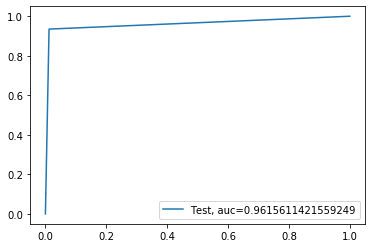

In [49]:
model_metrics(y_valid, predictions_cat_smote)

In [50]:
import lightgbm as lgb
lgb_smote = lgb.LGBMClassifier()
lgb_smote.fit(X_train, y_train)

LGBMClassifier()

In [51]:
Pkl_Filename_lgbm = "Pickle_lgbm_std_smote.pkl"  

with open(Pkl_Filename_lgbm, 'wb') as file:  
    pickle.dump(lgb_smote, file)

In [52]:
with open(Pkl_Filename_lgbm, 'rb') as file:  
    Pickled_Model_lgbm = pickle.load(file)

In [53]:
predictions_lgbm_smote = Pickled_Model_lgbm.predict(X_valid)

confusion matrix
[[225832   1843]
 [  9968 218259]]
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    227675
           1       0.99      0.96      0.97    228227

    accuracy                           0.97    455902
   macro avg       0.97      0.97      0.97    455902
weighted avg       0.97      0.97      0.97    455902

Accuracy for the test dataset 97.4%
ROC for the test dataset 97.4%


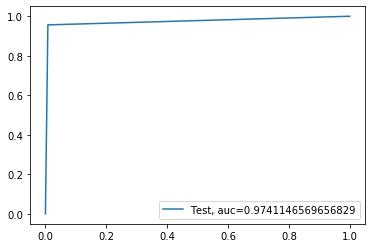

In [54]:
model_metrics(y_valid, predictions_lgbm_smote)

### Logistic regression Model

In [23]:
from sklearn.linear_model import LogisticRegression
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3), "penalty":["l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
lr_model = logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 138.9495494373136, 'penalty': 'l2'}
accuracy : 0.7626094548622792


In [25]:
import pickle
Pkl_Filename_lr = "Pickle_lr_std_smote.pkl"  

with open(Pkl_Filename_lr, 'wb') as file:  
    pickle.dump(lr_model, file)

In [26]:
with open(Pkl_Filename_lr, 'rb') as file:  
    Pickled_Model_lr = pickle.load(file)

In [28]:
predictions_lr_smote = Pickled_Model_lr.predict(X_valid)

confusion matrix
[[180405  47270]
 [ 61094 167133]]
Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77    227675
           1       0.78      0.73      0.76    228227

    accuracy                           0.76    455902
   macro avg       0.76      0.76      0.76    455902
weighted avg       0.76      0.76      0.76    455902

Accuracy for the test dataset 76.2%
ROC for the test dataset 76.2%


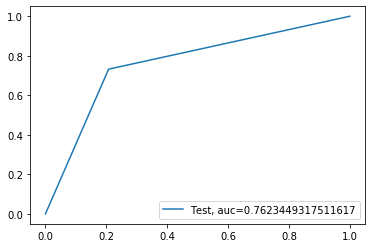

In [32]:
model_metrics(y_valid, predictions_lr_smote)

### Training Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
from sklearn.model_selection import GridSearchCV

n_folds = 5

params = {'bootstrap': [True, False]}

rf = RandomForestClassifier(
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=20,
                             n_estimators=200)
rf_model_smote = GridSearchCV(rf, params, cv=n_folds, scoring='neg_mean_squared_error')
rf_model_smote.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=20,
                                              min_samples_leaf=100,
                                              min_samples_split=200,
                                              n_estimators=200),
             param_grid={'bootstrap': [True, False]},
             scoring='neg_mean_squared_error')

In [40]:
# scores of GridSearch CV
rf_scores = rf_model_smote.cv_results_
pd.DataFrame(rf_scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,358.911652,6.836534,5.489538,0.108516,True,{'bootstrap': True},-0.107069,-0.107091,-0.108459,-0.108547,-0.109907,-0.108215,0.001059,2
1,538.727744,8.663032,5.478198,0.051136,False,{'bootstrap': False},-0.104298,-0.106704,-0.105155,-0.108167,-0.107026,-0.106270,0.001378,1


In [41]:
predictions_rf_somte = rf_model_smote.predict(X_valid)

### Random forest model metrics

confusion matrix
[[214454  13221]
 [ 35890 192337]]
Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90    227675
           1       0.94      0.84      0.89    228227

    accuracy                           0.89    455902
   macro avg       0.90      0.89      0.89    455902
weighted avg       0.90      0.89      0.89    455902

Accuracy for the test dataset 89.2%
ROC for the test dataset 89.2%


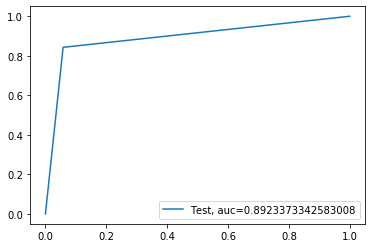

In [43]:
model_metrics(y_valid, predictions_rf_somte)

In [44]:
import pickle
Pkl_Filename_rf = "Pickle_rf_std_smote.pkl"  

with open(Pkl_Filename_rf, 'wb') as file:  
    pickle.dump(rf_model_smote, file)

### Training lightGBM Model

In [68]:
# hyperparameter tuning with LightGBM
from sklearn.model_selection import GridSearchCV
folds = 3

param_grid = {'learning_rate': [0.01,0.05, 0.1], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': [500,1000]}          


lgbm_model = lgb.LGBMClassifier(bagging_fraction=0.8, max_depth=10, feature_fraction=0.4,
                                  boosting_type='gbdt')

model_lgbm_cv = GridSearchCV(estimator = lgbm_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [69]:
model_lgbm_cv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 127.0min finished


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=3,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      feature_fraction=0.4, max_depth=10),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [500, 1000],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [70]:
lgbm_cv_results = pd.DataFrame(model_lgbm_cv.cv_results_)
lgbm_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,104.438253,0.223796,4.210135,0.046340,0.01,500,0.3,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
1,104.010789,0.486849,4.175606,0.022562,0.01,500,0.6,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
2,103.834553,0.258338,4.221973,0.047451,0.01,500,0.9,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
3,183.513491,0.859456,8.806904,0.036521,0.01,1000,0.3,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
4,185.030466,0.291234,8.889701,0.062117,0.01,1000,0.6,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
5,184.489857,1.482684,8.795173,0.064026,0.01,1000,0.9,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
6,88.351297,0.354453,4.236718,0.037604,0.05,500,0.3,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
7,89.068992,0.330871,4.255047,0.036313,0.05,500,0.6,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
8,88.438215,0.535480,4.226954,0.040624,0.05,500,0.9,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
9,145.563328,1.004962,7.804265,0.033795,0.05,1000,0.3,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",0.997921,0.997921,0.997804,0.997882,0.000055,6,0.998901,0.998877,0.998885,0.998888,0.000010


In [54]:
import lightgbm as lgb
lgb_smote_opt = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01,
                                  bagging_fraction=0.8, max_depth=10, feature_fraction=0.4,
                                  boosting_type='gbdt')
lgb_smote_opt.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.4, learning_rate=0.01,
               max_depth=10, n_estimators=1000)

In [61]:
Pkl_Filename_lgbm_opt = "Pickle_lgbm_std_smote_opt.pkl"  

with open(Pkl_Filename_lgbm_opt, 'wb') as file:  
    pickle.dump(lgb_smote_opt, file)

In [62]:
with open(Pkl_Filename_lgbm_opt, 'rb') as file:  
    Pickled_Model_lgbm_opt = pickle.load(file)

In [63]:
predictions_lgbm_smote_opt = Pickled_Model_lgbm_opt.predict(X_valid)

### Light GBM Model metrics

confusion matrix
[[225849   1826]
 [ 10813 217414]]
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    227675
           1       0.99      0.95      0.97    228227

    accuracy                           0.97    455902
   macro avg       0.97      0.97      0.97    455902
weighted avg       0.97      0.97      0.97    455902

Accuracy for the test dataset 97.2%
ROC for the test dataset 97.2%


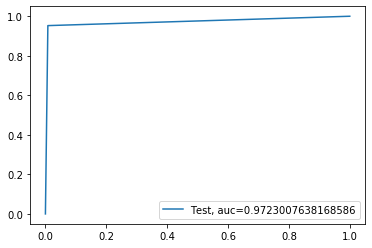

In [67]:
model_metrics(y_valid, predictions_lgbm_smote_opt)

### Training AdaBoost Model

In [49]:
ada_boost_smote = AdaBoostClassifier(n_estimators=500, random_state=0)

In [50]:
ada_boost_smote.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=0)

In [51]:
Pkl_Filename_ada_smote = "Pickle_ada_std_smote.pkl"  

In [54]:
dumpModel(Pkl_Filename_ada_smote, ada_boost_smote)

In [56]:
ada_boost_model_smote = loadModel(Pkl_Filename_ada_smote)

Loaded model ::  AdaBoostClassifier(n_estimators=500, random_state=0)


In [57]:
predictions_ada_smote = ada_boost_model_smote.predict(X_valid)

### Adaboost model Metrics

Printing the metrics for Model :  Ada Boost Classification with SMOTE
confusion matrix
[[222876   4799]
 [ 15362 212865]]
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    227675
           1       0.98      0.93      0.95    228227

    accuracy                           0.96    455902
   macro avg       0.96      0.96      0.96    455902
weighted avg       0.96      0.96      0.96    455902

Accuracy for the test dataset 95.6%
ROC for the test dataset 95.6%


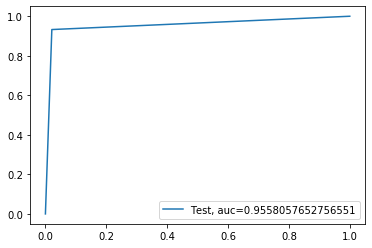

In [58]:
model_metrics(y_valid, predictions_ada_smote, "Ada Boost Classification with SMOTE")

### Testing

In [30]:
test_transactions = pd.read_csv('test_transaction.csv')
print(test_transactions.shape)

(506691, 393)


In [31]:
test_identity = pd.read_csv('test_identity.csv')

In [34]:
na_cols_test = check_NA_Cols_by_percentage(test_transactions, 0.9)    
top_value_cols_test = check_top_values(test_transactions, 0.9)   

drop_cols_test = list(set(na_cols_test + top_value_cols_test))
transactions = test_transactions.drop(drop_cols_test, axis=1)

456021.9
count of columns where 90.0 % of data is NA :  1
list of columns where values are NA : 
  ['dist2']


In [3]:
import matplotlib.pylab as plt
from matplotlib import pyplot